# Global Setting

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import acovf
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly
import xgboost as xgb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

##### Load data

In [20]:
sales = pd.read_csv('../data/sales_products_ts.csv')
products_info = pd.read_csv("../data/products_statistics.csv")

Define error functions

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

def wape(y_true, y_pred):
    acovf_vals = acovf(y_true, unbiased=False)
    return np.sum(np.abs(y_true - y_pred) / acovf_vals) * 100


Define metrics dataframe

In [75]:
metrics = pd.DataFrame(columns=['id','model','rmse', 'mape', 'mase'])

Replace outliers function

In [7]:
def replace_outliers(df):
    q3 = np.quantile(df['quantity'], 0.75)
    q1 = np.quantile(df['quantity'], 0.25)
    iqr = np.subtract(*np.percentile(df['quantity'], [75, 25], interpolation='linear', axis=0))
    max_limit = q3 + (1.5 * iqr)
    min_limit = q1 - (1.5 * iqr)
    df.loc[df['quantity'] > max_limit, 'quantity'] = max_limit
    df.loc[df['quantity'] < min_limit, 'quantity'] = min_limit

    return df


Preprocessing data

In [8]:
def preprocessing(df):
    id_list = sales['id'].unique()
    df['date'] = pd.DatetimeIndex(df.date)
    df = df.sort_values('date')
    df = df.reset_index(drop=True)
    df.index = pd.PeriodIndex(df.date, freq='W')
    df =  replace_outliers(df)
    df['log'] = np.log1p(df.quantity)
    df = df[['id','date', 'quantity', 'log']]
    return df, id_list

Plot the time series

In [9]:
def initial_plots(df, item):
    fig, (a1,a2) = plt.subplots(1,2, figsize=(15, 5))
    a1.plot(df.date, df['quantity'])
    a1.set_title(f'Original Serie - {item}')
    a2.plot(df.date, df['log'], color='r')
    a2.set_title(f'Log Transformation - {item}')
    fig.tight_layout()
    os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
    fig.savefig(f'../scale_outputs/{item}/images/ts_plot.png')
    plt.show()
    return fig

Train-test split

In [71]:
def split(df):
  weeks_train = round((max(df['date']) - min(df['date'])).days / 7 * 0.8)
  split_date = min(df['date']) + timedelta(weeks=weeks_train)
  train = df[df['date']< split_date] 
  test = df[df['date'] >= split_date]
  return split_date, train, test

Mean

In [11]:
def apply_mean_model(df, train, test, item):
    mean_model = train.log.mean()
    test['qtyMean'] = np.expm1(mean_model)
    df = df.merge(test[['qtyMean']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyMean'])
    os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/mean_model.png')
    row = {'id': item, 
         'model': 'mean', 
         'rmse': rmse(test.quantity,test.qtyMean),  
         'mape': mape(test.quantity,test.qtyMean),  
         'wape': wape(test.quantity,test.qtyMean)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, test

Linear model
* Time difference 

In [12]:
def apply_linear_model(df, train, test, item):
    train['timeIndex'] = train.date - train.date.min()
    train["timeIndex"] =  train["timeIndex"]/np.timedelta64(1, 'W')
    train["timeIndex"] = train["timeIndex"].round(0).astype(int)
    test['timeIndex'] = test.date - train.date.min() # verificar si se compara contra el date de train o test
    test["timeIndex"] =  test["timeIndex"]/np.timedelta64(1, 'W')
    test["timeIndex"] = test["timeIndex"].round(0).astype(int)
    model = smf.ols('log ~ timeIndex', data = train).fit()
    model_linear_pred = model.predict(test)
    test['qtyLinear'] = np.expm1(model_linear_pred)
    df = df.merge(test[['qtyLinear','timeIndex']], how= 'left', left_index=True, right_index=True)
    #plot = df.plot(kind="line", x="timeIndex", y = "qtyLinear")
    #plt.plot(df.timeIndex,model_linear_pred, '-')
#     os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
#     fig = plot.get_figure()
#     fig.savefig(f'../scale_outputs/{item}/images/linear_model.png')
    row = {'id': item, 
         'model': 'Linear model', 
         'rmse': rmse(test.quantity,test.qtyLinear),  
         'mape': mape(test.quantity,test.qtyLinear),  
         'wape': wape(test.quantity,test.qtyLinear)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, train, test



Random Walk

In [13]:
def apply_random_walk(df, train, test, item):
    train['lag'] = train.quantity.shift()
    #train.plot(kind= "scatter", y = "log", x = "lag_log", s = 50);
    test['qtyRW'] = train.lag.tail(n=1).values[0]
    df = df.merge(test[['qtyRW']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyRW'])
    os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/random_walk_model.png')
    row = {'id': item, 
         'model': 'Random Walk', 
         'rmse': rmse(test.quantity,test.qtyRW),  
         'mape': mape(test.quantity,test.qtyRW),  
         'wape': wape(test.quantity,test.qtyRW)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, train, test

Moving Average

In [14]:
def apply_moving_average(df, train, test, item):
    train['log_MA4'] = df.log.rolling(window = 4).mean()
    test['qtyMA4'] = np.expm1(train.log_MA4.tail(n=1).values[0])
    df = df.merge(test[['qtyMA4']], how= 'left', left_index=True, right_index=True)
#     plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyMA4'])
#     fig = plot.get_figure()
#     fig.savefig(f'../scale_outputs/{item}/images/moving_average.png')
    row = {'id': item, 
         'model': 'Moving average', 
         'rmse': rmse(test.quantity,test.qtyMA4),  
         'mape': mape(test.quantity,test.qtyMA4),  
         'wape': wape(test.quantity,test.qtyMA4)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, train, test
    

Arima

In [16]:
def apply_arima(df, train, test, item):
    ts_log = train.log
    model = auto_arima(ts_log,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )
    test['qtyArima'] = np.expm1(model.predict(n_periods =len(df.index)))
    df = df.merge(test[['qtyArima']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyArima'])
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/arima.png')
    row = {'id': item, 
         'model': 'Arima', 
         'rmse': rmse(test.quantity,test.qtyArima),  
         'mape': mape(test.quantity,test.qtyArima),  
         'wape': wape(test.quantity,test.qtyArima)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, test

Prophet

$Y_t = g(t) + s(t) + h(t) + e_t$

* $g(t)$ growth term
* $s(t)$: seasonal patterns
* $h(t)$: holidays effects
* $e_t$: error term

In [17]:
def tuning_hyperparameters_prophet(df, train, test, item, split_date):
    new_df = pd.DataFrame({'ds': df.index.to_timestamp(),'y':df.log}).reset_index()
    new_df = new_df.drop('date', axis=1)
    param_grid = {  
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative']
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params)
        m.add_country_holidays(country_name='ES')
        m.fit(new_df) 
        df_cv = cross_validation(m, initial='500 days', period='30 days', horizon='30 days', parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])
        
    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    #print(tuning_results)

    # Find the best parameters
    best_params = all_params[np.argmin(rmses)]
    return new_df, best_params

In [181]:
def apply_prophet(df, p_df, best_params, test, item, split_date):
    auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                        seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                        seasonality_mode=best_params['seasonality_mode'])
    # Add holidays
    auto_model.add_country_holidays(country_name='ES')
    # Fit the model
    auto_model.fit(p_df)
    # Cross validation
    days = (split_date - p_df.ds.min()).days
    days = str(days-30) + " days" # we substract 30 days to ensure test date period
    auto_model_cv = cross_validation(auto_model, initial=days, period='30 days', horizon = '30 days', parallel="processes")
    # Model performance metrics
    auto_model_cv_p = performance_metrics(auto_model_cv, rolling_window=1)
    # save results for test split (exponential transformation)
    auto_model_cv_test = auto_model_cv[auto_model_cv['ds'] >= split_date]
    auto_model_cv_test.index = pd.PeriodIndex(auto_model_cv_test.ds, freq='W')
    test['qtyProphet'] = np.expm1(auto_model_cv_test.yhat)
    df = df.merge(test[['qtyProphet']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyProphet'])
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/prophet.png')
    # save metrics
    row = {'id': item, 
         'model': 'Prophet', 
         'rmse': rmse(test.quantity,test.qtyProphet),  
         'mape': mape(test.quantity,test.qtyProphet),  
         'wape': wape(test.quantity,test.qtyProphet)
         }

    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)
    
    return df, test
    


In [60]:
sales, id_list = preprocessing(sales)

Multiple time series loop

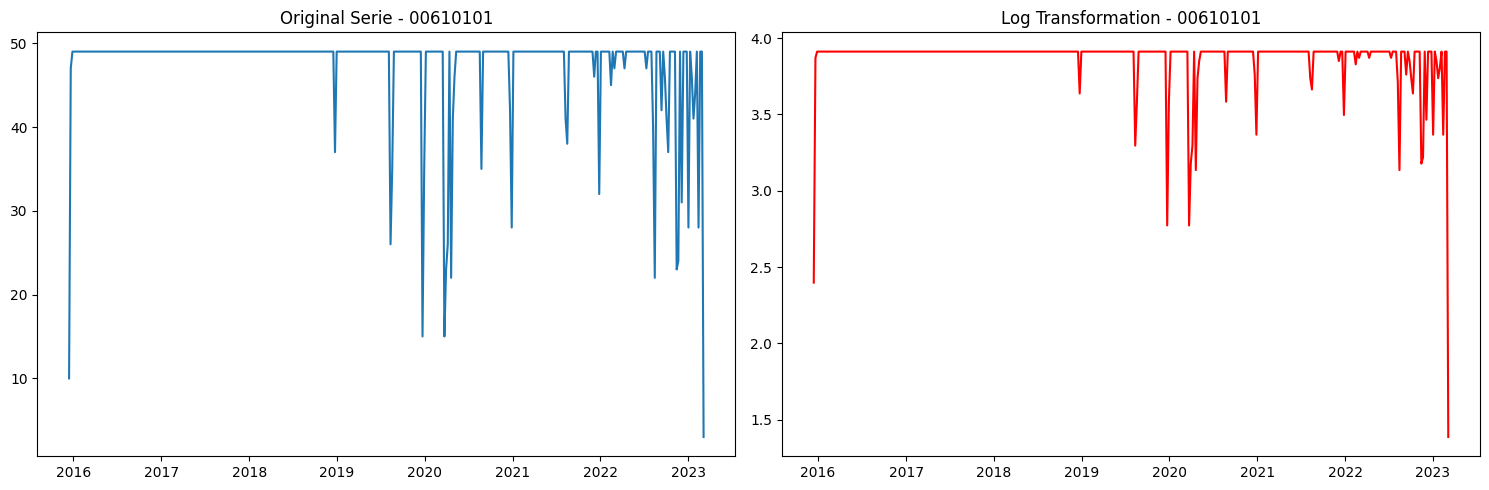

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-5.651, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-117.692, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.45 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-48.299, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-157.741, Time=0.73 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=-166.788, Time=1.82 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=-170.957, Time=3.06 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=-179.491, Time=6.11 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=15.98 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=12.64 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=-154.676, Time=3.04 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=-184.285, Time=4.84 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=-176.392, Time=4.43 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=19.83 sec
 ARIMA(2,1,0)(4,1,1)[12]             : 

KeyboardInterrupt: 

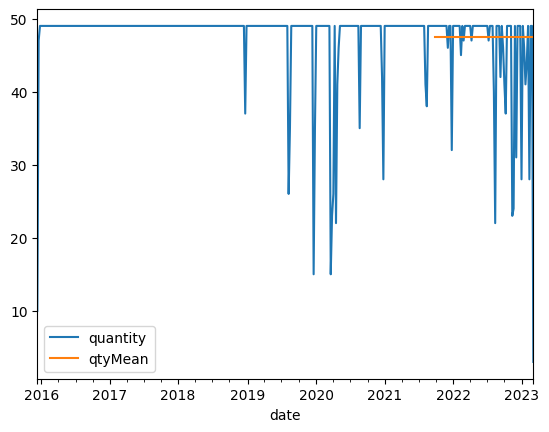

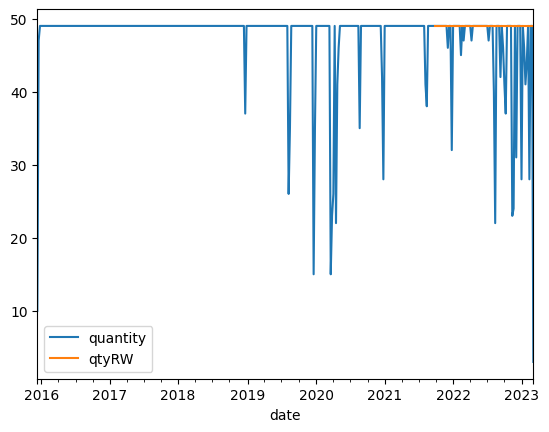

In [182]:
for item in id_list:
    one_product = sales[sales['id']==item]
    one_product = one_product.drop_duplicates()
    ts_plot = initial_plots(one_product, item)
    split_date, train, test = split(one_product)
    one_product, test = apply_mean_model(one_product, train, test, item)
    one_product, train, test = apply_linear_model(one_product, train, test, item)
    one_product, train, test = apply_random_walk(one_product, train, test, item)
    one_product, train, test = apply_moving_average(one_product, train, test, item)
    one_product, test = apply_arima(one_product, train, test, item)
    prophet_product, best_params = tuning_hyperparameters_prophet(one_product, train, test, item, split_date)
    one_product, test = apply_prophet(one_product, prophet_product, best_params, test, item, split_date)

In [ ]:
id_ex = '17410306'
m = sales[sales['id']== id_ex]

21:59:59 - cmdstanpy - INFO - Chain [1] start processing
21:59:59 - cmdstanpy - INFO - Chain [1] done processing
21:59:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
21:59:59 - cmdstanpy - INFO - Chain [1] start processing
22:00:02 - cmdstanpy - INFO - Chain [1] done processing


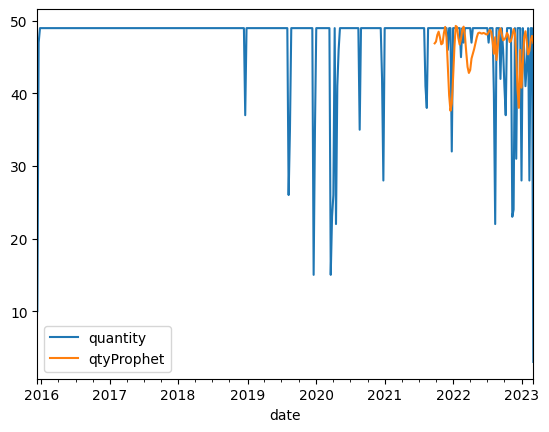

In [179]:
x = apply_prophet(one_product, best_params, test, item, split_date)


In [177]:
metrics

,id,model,rmse,mape,mase,wape
0,00610101,mean,8.497191,0.306761,NaN,-45639.389445
1,00610101,Linear model,8.228781,0.309634,NaN,-44328.628596
2,00610101,Random Walk,8.975845,0.302325,NaN,-47018.339360
3,00610101,Moving average,8.975845,0.302325,NaN,-47018.339360
4,00610101,mean,8.497191,0.306761,NaN,-45639.389445
5,00610101,Linear model,8.228781,0.309634,NaN,-44328.628596
6,00610101,Random Walk,8.975845,0.302325,NaN,-47018.339360
7,00610101,Moving average,8.975845,0.302325,NaN,-47018.339360
8,00610101,Prophet,8.599468,0.312883,NaN,-47141.019854
9,00610101,Prophet,8.599468,0.312883,NaN,-47141.019854
